## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, RandomAdjustSharpness, Grayscale, Normalize
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.Transformer import *

In [2]:
torch.manual_seed(109)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [4]:
size = 32
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), Grayscale(1), 
                          RandomAdjustSharpness(2, p=1),
                          ToTensor(), Normalize(mean=[0.4814], std=[0.2136])])

In [5]:
root = 'chest_xray/train'
train_data = create_dataset(root, transformation)
train_loader = produce_loader(train_data, batch_size, shuffle=True)

In [6]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [7]:
root = 'chest_xray/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[1218, 2799, 4274, 5856, 4366, 3721, 4422, 811, 1110]


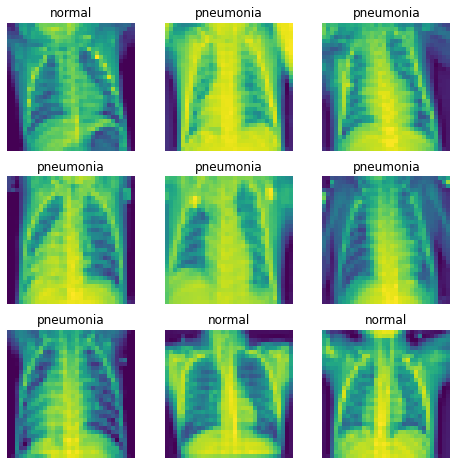

In [8]:
visualize_data(train_data)

[531, 149, 380, 59, 555, 309, 358, 283, 40]


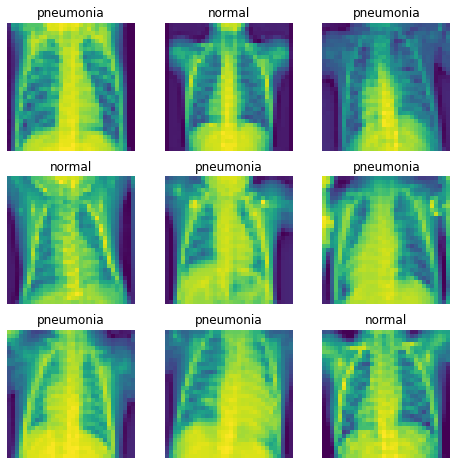

In [9]:
visualize_data(test_data)

## Initialize Model

Parameters that can be changed:

1) Kernel size

2) hidden - no. of neurons in each layer and no. of layers)

3) window - window size for max-pooling

4) blocks - no.of neurons in transformer block


In [10]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [11]:
from math import floor
# number of convolutional 'embedding' layers and their sizes
hidden = [1, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]
dropout=0.5

In [12]:
model = Transformer(hidden, kernel_size, window, blocks,dropout).to(device)
print(model)

Transformer(
  (conv_combined): Sequential(
    (0): ConvEmbed(
      (conv): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): ConvEmbed(
      (conv): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): ConvEmbed(
      (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (blocks_combined): Sequential(
    (0): TransformerBlock(
      (attention): AttentionLayer(
        (query): Linear(in_features=5408, out_feat

## Training Model

In [13]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [14]:
optimizer = create_adam_optimizer(model, lr = 0.001)

In [15]:
"""
train

Function used to train the model. Returns four lists for the purposes of plotting performance curves.

Parameters:
device - device to use
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs - epochs to train the model
criterion - loss function to use (default is cross entropy)
patience - number of iterations validation loss is allowed to increase before training is stopped (default is 3)
autoencoder - autoencoder to use, if any (default is None)
checkpoint - if True, a checkpoint of the model (and optimizer) will saved if the model either has the current
             lowest validation loss, has a validation accuracy of at least 90%, or both (default is True)

Returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves.

"""
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 20)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.4609375
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.46875
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.49360795454545453
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.51416015625
Epoch 1/20, Batch number: 20, Cumulated accuracy: 0.5394345238095238
Epoch 1/20, Batch number: 25, Cumulated accuracy: 0.5652043269230769
Epoch 1/20, Batch number: 30, Cumulated accuracy: 0.5814012096774194
Epoch 1/20, Batch number: 35, Cumulated accuracy: 0.5980902777777778
Epoch 1/20, Batch number: 40, Cumulated accuracy: 0.6149009146341463
Epoch 1/20, Batch number: 45, Cumulated accuracy: 0.6299252717391305
--- Epoch 1/20: Train loss: 0.6534, Train accuracy: 0.6311
--- Epoch 1/20: Val loss: 0.3796, Val accuracy: 0.8752
Epoch 2/20, Batch number: 0, Cumulated accuracy: 0.6875
Epoch 2/20, Batch number: 5, Cumulated accuracy: 0.7395833333333334
Epoch 2/20, Batch number: 10, Cumulated accuracy: 0.7322443181818182
Epoch 2/20, Batch number: 15,

Epoch 11/20, Batch number: 30, Cumulated accuracy: 0.8117439516129032
Epoch 11/20, Batch number: 35, Cumulated accuracy: 0.8151041666666666
Epoch 11/20, Batch number: 40, Cumulated accuracy: 0.8140243902439024
Epoch 11/20, Batch number: 45, Cumulated accuracy: 0.8143682065217391
--- Epoch 11/20: Train loss: 0.4264, Train accuracy: 0.8151
--- Epoch 11/20: Val loss: 0.3184, Val accuracy: 0.9111
Epoch 12/20, Batch number: 0, Cumulated accuracy: 0.8203125
Epoch 12/20, Batch number: 5, Cumulated accuracy: 0.8046875
Epoch 12/20, Batch number: 10, Cumulated accuracy: 0.7997159090909091
Epoch 12/20, Batch number: 15, Cumulated accuracy: 0.81103515625
Epoch 12/20, Batch number: 20, Cumulated accuracy: 0.8128720238095238
Epoch 12/20, Batch number: 25, Cumulated accuracy: 0.8125
Epoch 12/20, Batch number: 30, Cumulated accuracy: 0.8165322580645161
Epoch 12/20, Batch number: 35, Cumulated accuracy: 0.8157552083333334
Epoch 12/20, Batch number: 40, Cumulated accuracy: 0.8170731707317073
Epoch 12/20

## Testing Model & Performance Curves

In [16]:
"""
test

Function used to obtain the validation or test loss and accuracy of the model. Can also return
additional lists used for confusion matrix computation.

Parameters:
device - device to use
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  followed by values of the test loss and test accuracy (default is False)

By default, returns values of the test loss and test accuracy. Set get_predictions to True (as mentioned above) to
obtain the lists of true labels and list of preidctions made by the model on top of the test loss and accuracy.

"""
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)

Test loss: 0.3059, Test accuracy: 0.8872


Precision: 0.8784067085953878
Recall: 0.9812646370023419
F1 score: 0.9269911504424779


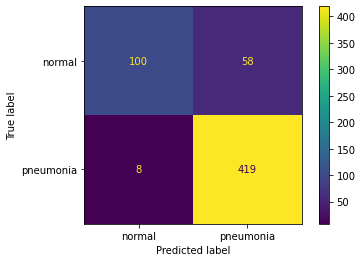

In [17]:
'''
Takes in lists of the true labels and model predictions,
then computes the precision, recall, and f1 score

'''
show_metrics(true_labels, model_preds)

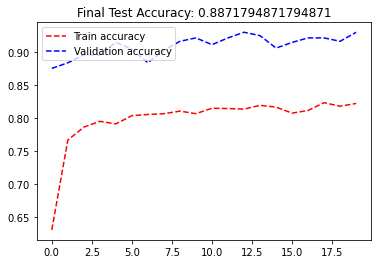

In [18]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

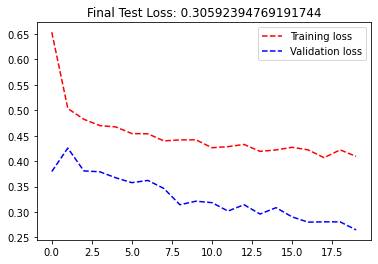

In [19]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [20]:
test_loader2 = produce_loader(test_data, 1)

In [21]:
"""
get_pictures_test

A simplified version of the test function that returns four lists
used for image visualization and confusion matrix computation.

Parameters:
device - device to use
model - model to train
data_loader - chosen (testing) data loader
autoencoder - autoencoder to use, if any (default is None)

Returns a list of correctly predicted images, a list of incorrectly predicted images, a list of true labels,
and a list of predictions made by the model each of length equal to the length of the data loader provided.

"""
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2)

Precision: 0.884453781512605
Recall: 0.9859484777517564
F1 score: 0.9324473975636766


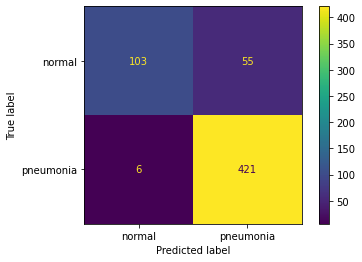

In [22]:
show_metrics(true_labels2, model_preds2)

[454, 260, 164, 304, 490, 139, 289, 198, 446, 494, 196, 285, 1, 383, 53, 61, 166, 330, 46, 363, 111, 290, 180, 520, 148]


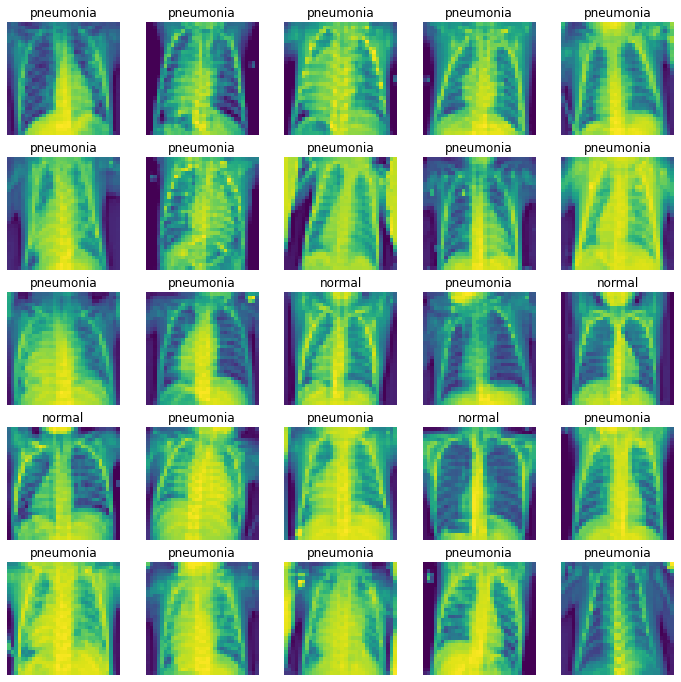

In [23]:
visualize_data(correct_list, (12,12), 5)

[29, 34, 29, 60, 1, 51, 23, 20, 44, 36, 17, 58, 37, 21, 2, 34, 1, 5, 33, 41, 19, 46, 8, 26, 45]


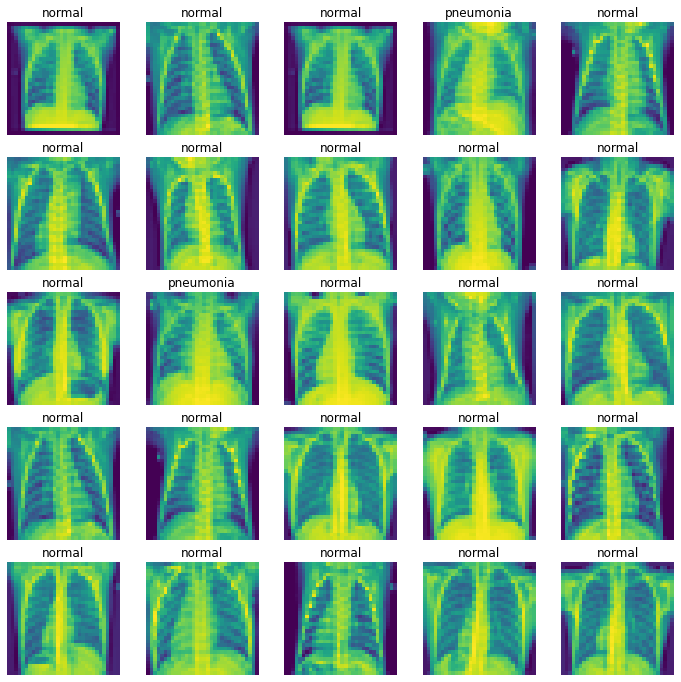

In [24]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './Transformer_10epochs')